# Predict weekly data, single city (Moving average and auto-regression)

In [1]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd

import matplotlib.pyplot as plt

from data.india_pollution import india_pollution
from data.stock_prices import stock_prices
from data.list_of_tuples import list_of_tuples
from data.dataset import Dataset, Result

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

/Users/frankkelly/Library/Caches/pypoetry/virtualenvs/india-air-pollution-study-xopDDJl_-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
chosen_name = "Bengaluru"
# chosen_name = "JPM
# chosen_name = "linear + noise"

# input_dataframe, time_unit, number_columns = list_of_tuples(200)
# input_dataframe, time_unit, number_columns = stock_prices(chosen_name)
dataset_object = india_pollution(city=[chosen_name])


input_dataframe = dataset_object.values

display(input_dataframe.head())
input_dataframe.describe(include=(np.number))

Path air-quality-data-in-india exists


,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-04,30.65,70.46,15.807500,6.032500,6.910000,19.637500
2015-01-11,30.65,70.46,16.888571,1.561429,6.492857,27.168571
2015-01-18,30.65,70.46,16.485714,6.827143,13.562857,22.660000
2015-01-25,30.65,70.46,41.432564,6.372857,42.478571,12.630000
2015-02-01,30.65,70.46,21.145714,2.301429,10.921429,13.434286


,PM2.5,PM10,O3,CO,SO2,NO2
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,35.931781,81.351225,33.339421,1.842274,5.513256,27.929567
std,17.395080,30.741989,16.138142,2.854199,3.064122,11.466776
min,11.872857,21.125714,4.005714,0.298571,1.615714,6.667143
25%,22.659886,62.066071,19.349406,0.769286,3.955357,19.324286
50%,32.567857,70.460000,31.428571,0.950714,5.197857,27.894286
75%,43.567143,98.357143,44.760449,1.185714,6.392857,34.370000
max,149.989207,208.570000,78.690000,22.202857,42.478571,77.882857


<AxesSubplot:xlabel='Date'>

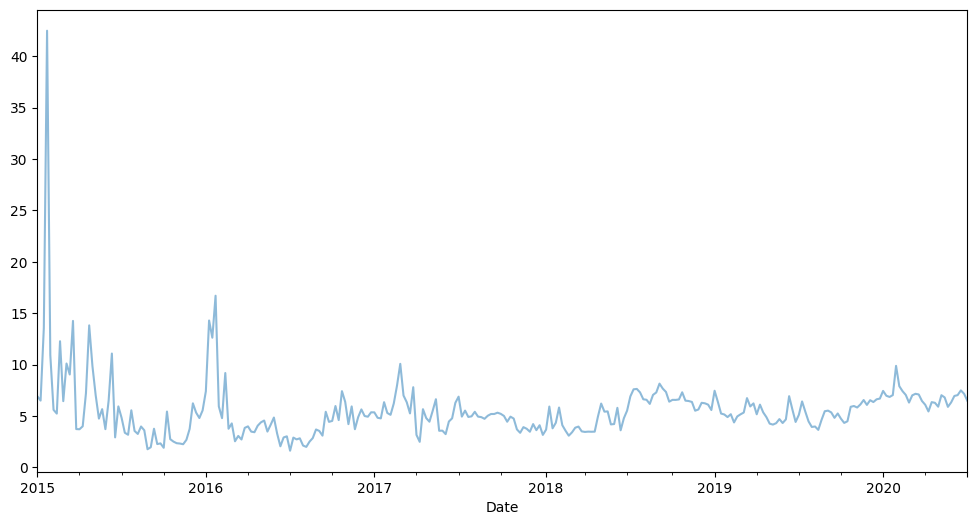

In [6]:
input_dataframe["SO2"].plot(figsize=(12, 6), alpha=0.5)

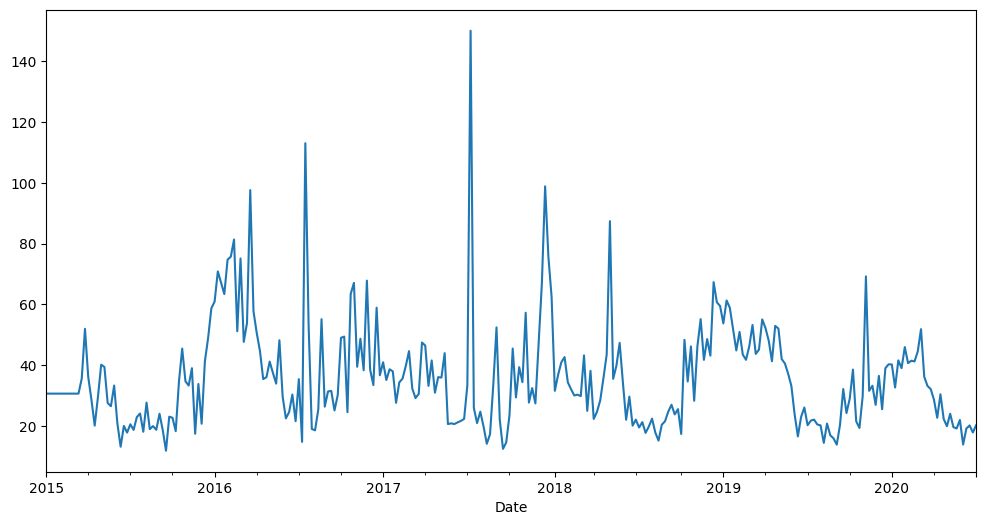

In [7]:
input_dataframe["PM2.5"].plot(figsize=(12, 6))
plt.show()

## Moving Average 

In [10]:
from arch.unitroot import KPSS, ADF

In [11]:
delhi_df_weekly = input_dataframe

In [12]:
augment_dickey_fuller = ADF(delhi_df_weekly["PM2.5"])
augment_dickey_fuller

Test Statistic,-4.797
P-value,0.000
Lags,3


In [13]:
def check_for_stationarity(series):
    print(
        "The null hypothesis of the Augmented Dickey-Fuller test is that there is a unit root."
    )
    test_result = ADF(series).pvalue < 0.05
    print(f"p-value: {ADF(series).pvalue}")
    print(f"Accept the null hypothesis? {test_result}")
    if not test_result:
        print("There isn't a unit root => Data is stationary.")
    else:
        print("There is a unit root => Data is non-stationary.")
    return test_result


check_for_stationarity(delhi_df_weekly["PM2.5"])

The null hypothesis of the Augmented Dickey-Fuller test is that there is a unit root.
p-value: 5.518415384180583e-05
Accept the null hypothesis? True
There is a unit root => Data is non-stationary.


True

In [14]:
from pmdarima.arima.utils import ndiffs


def get_differencing_values(series):
    diff_values = ndiffs(series, test="adf")
    print(f"Differencing Values: {diff_values}")
    return diff_values


diff_value = get_differencing_values(delhi_df_weekly["PM2.5"])

Differencing Values: 0


As a reminder, ARIMA is parametrized with parameters p, d, q, where:  
* p is for the autoregressive model: AR(p)  
* d is for the integration 
* q is for the moving average: MA(q)  

In [15]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(endog=delhi_df_weekly["PM2.5"], order=(1, diff_value, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                  288
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1190.938
Date:                Thu, 08 Sep 2022   AIC                           2387.875
Time:                        15:05:25   BIC                           2398.864
Sample:                    01-04-2015   HQIC                          2392.279
                         - 07-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.8617      2.641     13.578      0.000      30.685      41.038
ar.L1          0.4912      0.034     14.537      0.000       0.425       0.557
sigma2       228.5068      9.649     23.683      0.0

In [61]:
from statsmodels.tsa.forecasting.stl import STLForecast

mod = STLForecast(
    delhi_df_weekly["PM2.5"],
    sm.tsa.arima.ARIMA,
    model_kwargs=dict(order=(1, diff_value, 0), trend="t"),
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1417.228
Date:                Mon, 15 Aug 2022   AIC                           2840.457
Time:                        12:17:27   BIC                           2851.446
Sample:                    01-04-2015   HQIC                          2844.860
                         - 07-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5577      0.115      4.840      0.000       0.332       0.784
ar.L1          0.8910      0.022     41.003      0.000       0.848       0.934
sigma2      1095.0053     45.881     23.866      0.0

In [16]:
STEPS = 20
forecasts_df = res.get_forecast(steps=STEPS).summary_frame()

## Comparing predictions to actual values

In [17]:
forecasts_df.head()

PM2.5,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-07-12,28.176584,15.116441,-1.451095,57.804263
2020-07-19,32.086635,16.841741,-0.922570,65.095841
2020-07-26,34.007321,17.232197,0.232835,67.781807
2020-08-02,34.950795,17.325094,0.994235,68.907356
2020-08-09,35.414247,17.347435,1.413898,69.414595


In [49]:
import matplotlib.pyplot as plt



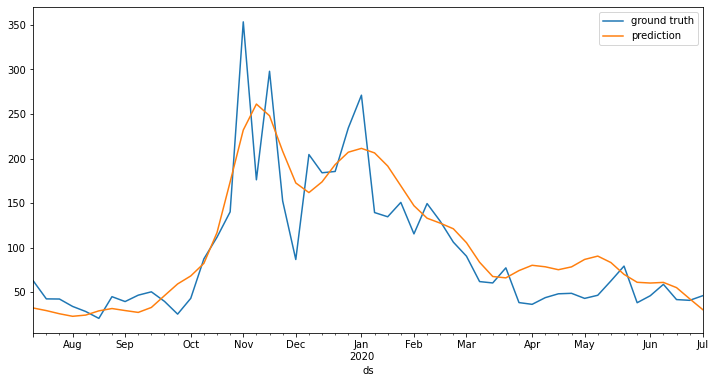

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

forecast_series = forecast.set_index(keys=["ds"]).iloc[-nobs:, :]
ground_truth_series = test.rename(columns={"Date": "ds", "PM2.5": "y"}).set_index(
    keys=["ds"]
)

ground_truth_series["y"].plot()
forecast_series["yhat"].plot()


ax.legend(["ground truth", "prediction"])

In [69]:
def calculate_RMSE(ground_truth, forecast):
    return np.sqrt(np.mean((ground_truth - forecast) ** 2))


calculate_RMSE(ground_truth_series["y"], forecast_series["yhat"])

36.34970386744316

In [ ]:
#TODO: take single year's data, make prediction, then 2 years etc. (which timespan gives best prediction?)
#TODO: try a prediction for 2023 (each Indian city)
#TODO: Plot weekly prediction for each city
# consdier location in country also

# External datasets as well - wind speed / direction & temperature
# Which method performs best with Pollution data
# Which metrics to use to find which method perform the best